# Projet 7 : Implémentez un modèle de scoring
*Philippe LONJON (janvier 2020)*

---
Ce projet consiste à développer un modèle de scoring, qui donnera une prédiction sur la probabilité de défaut de paiement d'un client qui demande un prêt.
Il s'agit d'un problème :
* **Supervisé** : Les étiquettes (Défauts de paiement) sont connus
* **Classification** : Les valeurs à prédire sont des variables qualitatives
---
## Notebook 5 : Sélection du modèle
Le notebook comprend :
- La comparaison des modèles optimisés selon différentes métriques et le choix du modèle à garder
- La définition d'un seuil de décision
- La préparation des données pour le dashboard et le déploiement du modèle sous forme d'API

Les données pour le dashboard et le déploiement sont sauvegardées dans ``data/dashboard`` et ``data/API``.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import shap

# Divers
from time import time, strftime, gmtime
import gc
import pickle

# Module des fonctions du notebook
import fonctions08 as f

# Autoreload pour prise en compte des changments dans le module fonctions
%load_ext autoreload
%autoreload 1
%aimport fonctions08

In [2]:
# Heure démarrage
t0=time()

# Constantes
RANDOM_STATE = 1
NROWS = None
N_FOLDS = 5

# 1. Données de test et d'entrainement
On commence par charger les données de test et d'entrainement.

In [3]:
# Chargement des données
X_train = \
    f.import_csv("data/features/train_features_selected.csv", nrows=NROWS) \
    .set_index('SK_ID_CURR')

y_train = \
    f.import_csv("data/features/train_target.csv", nrows=NROWS) \
    .set_index('SK_ID_CURR')

X_test = \
    f.import_csv("data/features/test_features_selected.csv", nrows=NROWS) \
    .set_index('SK_ID_CURR')

y_test = \
    f.import_csv("data/features/test_target.csv", nrows=NROWS) \
    .set_index('SK_ID_CURR')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Memory usage of dataframe is 505.82 MB
Memory usage after optimization is: 164.84 MB
Decreased by 67.4%
Memory usage of dataframe is 3.28 MB
Memory usage after optimization is: 1.03 MB
Decreased by 68.7%
Memory usage of dataframe is 216.78 MB
Memory usage after optimization is: 69.06 MB
Decreased by 68.1%
Memory usage of dataframe is 1.41 MB
Memory usage after optimization is: 0.44 MB
Decreased by 68.7%
(215257, 307)
(215257, 1)
(92254, 307)
(92254, 1)


On recréé à nouveau un jeu d'entrainement avec des classes équilibrées.

In [4]:
# Train features et target balanced pour entrainement modele
target_0 = y_train[y_train['TARGET'] == 0]
target_1 = y_train[y_train['TARGET'] == 1]

# Sous-échantillon de la classe 0,
# de même longueur que l'échantillon de la classe 1
target_0_sample = target_0.sample(len(target_1), random_state=RANDOM_STATE)

# Sous-echantillons des données d'entrainement et des étiquettes 
# avec classes équilibrées
y_train_balanced = pd.concat([target_0_sample, target_1], axis=0)
X_train_balanced = X_train.loc[y_train_balanced.index, :]

# Dimensions des sous échantillons avec classes équilibrées
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(34754, 307)
(34754, 1)


# 2. Sélection du modèle
On va comparer les modèles obtenus après la phase d'optimisation des hyper-paramètres.<br>
On commence par récupérer les hyper-paramètres de chaque modèle.

In [5]:
# Chargement des modèles
ls_models = ['accuracy', 'auc', 'f1', 'precision', 'recall', 'log_loss']
models = {}

for model in ls_models:
    # Parametres du modèle
    params_file = 'data/model/params_' + model + '.sav'
    study = pickle.load(open(params_file, 'rb'))
    models[model] = {'params': study['model'], 'study': study['study']}

Puis on initialise un modèle pour chaque configuration, que l'on entraine avec les données ayant les classes équilibrées.

In [6]:
# Entrainement des modèles avec le sous-échantillon
for model in ls_models:
    # Initilisation modele final avec hyperparamètres optimisés
    mod = lgb.LGBMModel()
    _ = mod.set_params(**models[model]['params'])
    
    # Entrainement du modele
    mod.fit(X_train_balanced, np.ravel(y_train_balanced))
    models[model]['model'] = mod

On va ensuite comparer les performances des modèles, selon les principales métriques de classification.

In [7]:
# Création dataframe pour comparer les scores des modèles
eval_df = pd.DataFrame(index=models)

# Création dictionnaire pour stocker les roc curves
roc_curve_dict = {}

# lignes pour les modeles, colonnes pour les scores
for model in ls_models:
    # Prediction du modele
    preds = models[model]['model'].predict(X_test)
    models[model]['preds'] = preds
    
    # auc score
    eval_df.loc[model, 'auc_score'] = np.round(roc_auc_score(y_test, preds), 3)
    
    # log_loss
    eval_df.loc[model, 'log_loss'] = np.round(log_loss(y_test, preds), 3)

    # accuracy
    eval_df.loc[model, 'accuracy'] = \
        np.round(accuracy_score(y_test, np.rint(preds)), 3)

    # scores precision, recall, F1
    target_names = ['Non_default', 'Default']
    scores = classification_report(y_test, np.rint(preds),
                                   target_names=target_names,
                                   output_dict=True)
    
    for score in ['precision', 'recall', 'f1-score']:
        eval_df.loc[model, score] = np.round(scores['macro avg'][score], 3)
    
    # ROC curve
    roc_curve_dict[model] = {}
    roc_curve_dict[model]['fpr'], roc_curve_dict[model]['tpr'] , _ = \
        roc_curve(y_test, preds)

# Renommage de l'index
eval_df.index = [ 'model_optim_' + x for x in eval_df.index]

On commence par comparer les courbes ROC, on ne distingue pas de modèle plus performant que les autres.

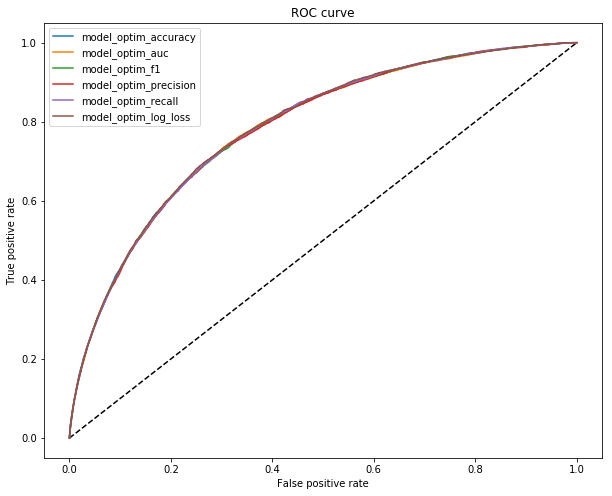

In [8]:
# Affichage des courbes ROC
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')

for model in ls_models:
    plt.plot(roc_curve_dict[model]['fpr'],
             roc_curve_dict[model]['tpr'],
             label='model_optim_'+model)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Affichage des scores des modèles, obtenus sur les données de test.

In [9]:
# Apercu des scores des modèles sur les données test
display(eval_df)

,auc_score,log_loss,accuracy,precision,recall,f1-score
model_optim_accuracy,0.785,0.564,0.712,0.572,0.713,0.553
model_optim_auc,0.784,0.564,0.712,0.573,0.714,0.553
model_optim_f1,0.784,0.564,0.712,0.572,0.712,0.552
model_optim_precision,0.783,0.564,0.712,0.573,0.714,0.553
model_optim_recall,0.785,0.564,0.712,0.572,0.712,0.553
model_optim_log_loss,0.786,0.563,0.713,0.573,0.714,0.554


Le modèle **model_optim_log_loss**, optimisé selon le log loss, obtient les meilleurs performances sur les données test, quel que soit la métrique d'évaluation.<br>
C'est donc ce modèle que l'on sélectionne.

# 3. Evaluation du seuil de probabilité pour classer un score en défaut
Maintenant que nous avons le modèle, nous allons déterminer un seuil de classification, c'est à dire, le niveau de probabilité à partir duquel le client sera classé en défaut de paiement.<br>
Pour cela nous allons évaluer l'impact de différents seuils de classification sur le portefeuille client, dans le cas d'un défaut de crédit, puis prendre celui qui permet une meilleure préservation du portefeuille.
#### Etape 1
On récupère par client : les défauts réels, les probabilités du modèle et les montants du crédit demandé

In [10]:
# Dataframe des défauts réel, probabilités de défaut et montants de crédit
preds_df = y_test.copy()
preds_df = preds_df.rename(columns={'TARGET': 'true_loan_status'})
preds_df['prob_default'] = models['log_loss']['preds']
preds_df['credit_amount'] = X_test['application_AMT_CREDIT']
preds_df.tail()

,true_loan_status,prob_default,credit_amount
SK_ID_CURR,,,
350388,0,0.319842,675000.0
279869,0,0.488247,323172.0
341412,1,0.597915,450000.0
253890,0,0.473650,171000.0
352980,0,0.311846,1800000.0


#### Etape 2
On va ensuite :
- définir des taux d'acceptation des demandes ($acceptance\space  rate$), en partant de 100% (toutes les demandes acceptée) jusqu'à 98%. Il n'est pas nécessaire de descendre plus bas, car il y a peu de clients qui font défaut.
- Pour chaque taux d'acceptation, on définit le seuil de classification associé ($threshold$).
- On peut alors determiner le nombre de demandes qui seront acceptées ($num\space accepted\space loans$), et calculer leur taux de défaut ($bad\space rate$), à partir des crédit qui feront réellement défaut.
- Pour terminer, on évalue le portefeuille à partir du montant moyen d'un crédit ($avg\space loan\space amount$). On considère ici que les défauts sont des défauts de crédit (perte du capital) :<br><br>
$$portfolio\space estimation = (num\space accepted\space loans * (1-bad\space rate) * avg\space loan\space amount) $$
$$-\space (num\space accepted\space loans * bad\space rate * avg\space loan\space amount)$$

In [11]:
# Taux d'acceptation des demandes
accept_rates = np.arange(1, 0.98, -0.001).round(3).tolist()

# Valeurs à sauvegarder
thresholds = []
nb_accepted_loans = []
bad_rates = []
loans_accepted_non_default = []
loans_accepted_default = []
portfolio_estimation = []
avg_loan_amount = []
estimate_value = []

for rate in accept_rates:
    # Taux de classification associé
    threshold = np.quantile(preds_df['prob_default'], rate)
    thresholds.append(threshold)
    
    # Statut prédit selon le taux de classification
    preds_df['pred_loan_status'] = preds_df['prob_default']\
        .apply(lambda x: 1 if x > threshold else 0)
    
    # Prêts acceptés 
    accepted_loans = preds_df[preds_df['pred_loan_status'] == 0]
    
    # Nombre de prêts acceptés
    count_accepted_loans = len(accepted_loans['true_loan_status'])
    nb_accepted_loans.append(count_accepted_loans)
    
    # Taux de défaut parmi les prêts acceptés
    bad_rate = (np.sum(accepted_loans['true_loan_status']) /
                count_accepted_loans)
    bad_rates.append(bad_rate)    
    
    # Montant moyen d'un prêt
    avg_loan = np.mean(preds_df['credit_amount'])
    avg_loan_amount.append(avg_loan)    

    # Estimation portefeuille
    estimate_value = ((count_accepted_loans *  (1-bad_rate) * avg_loan) - 
        (count_accepted_loans *  (bad_rate) * avg_loan)) / 1e6
    portfolio_estimation.append(estimate_value)
    
    preds_df.drop(['pred_loan_status'], axis=1, inplace=True)
    
# Création de la table de strategie
data_zip = zip(accept_rates,
               thresholds,
               nb_accepted_loans,
               bad_rates,
               avg_loan_amount,
               portfolio_estimation,)

columns = ['acceptance rate',
           'threshold',
           'num accepted loans',
           'bad rate',
           'avg loan amount',
           'portfolio estimation',]

strategy_table = pd.DataFrame(data_zip, columns=columns)

# Formatage des colonnes
strategy_table['acceptance rate'] = strategy_table['acceptance rate']\
    .map('{:.2%}'.format)

strategy_table['num accepted loans'] = strategy_table['num accepted loans']\
    .apply(lambda x : '{:,.0f}'.format(x).replace(',', ' '))

strategy_table['bad rate'] = strategy_table['bad rate']\
    .map('{:.2%}'.format)

strategy_table['avg loan amount'] = strategy_table['avg loan amount']\
    .apply(lambda x : '{:,.0f}'.format(x).replace(',', ' '))

strategy_table['portfolio estimation'] = strategy_table['portfolio estimation']\
    .apply(lambda x : '{:,.2f}M'.format(x).replace(',', ' '))

In [12]:
# Affichage de la table
display(strategy_table.head(11))

,acceptance rate,threshold,num accepted loans,bad rate,avg loan amount,portfolio estimation
0,100.00%,0.970889,92 254,8.07%,598 664,46 311.41M
1,99.90%,0.934184,92 161,8.01%,598 664,46 331.17M
2,99.80%,0.924932,92 069,7.96%,598 664,46 346.73M
3,99.70%,0.917936,91 977,7.90%,598 664,46 361.10M
4,99.60%,0.912514,91 884,7.87%,598 664,46 353.32M
5,99.50%,0.907547,91 792,7.83%,598 664,46 352.12M
6,99.40%,0.903322,91 700,7.79%,598 664,46 341.34M
7,99.30%,0.899350,91 608,7.75%,598 664,46 340.15M
8,99.20%,0.895684,91 515,7.71%,598 664,46 333.56M
9,99.10%,0.892190,91 423,7.68%,598 664,46 325.18M


# 4. Importance des variables du modèle
La librairie ``lightgbm`` permet de determiner l'importance des variables dans le modèle.<br>
Ici, il s'agit du nombre de fois que la variable est utilisée par le modèle.<br>

In [13]:
# Modele selectionné
model = models['log_loss']['model']

# Moyenne des features importances
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': list(X_train.columns),
    'importance': feature_importances
    })\
    .sort_values('importance', ascending=False)

print(feature_importance_df.head())

                      feature  importance
1    application_AMT_DURATION         329
0  application_EXT_SOURCE_ALL         248
5      application_DAYS_BIRTH         224
6    application_EXT_SOURCE_2         209
2   application_DAYS_EMPLOYED         204


Une fois les variables triées par ordre d'importance décroissante, on peut les afficher et identifier les plus importantes.

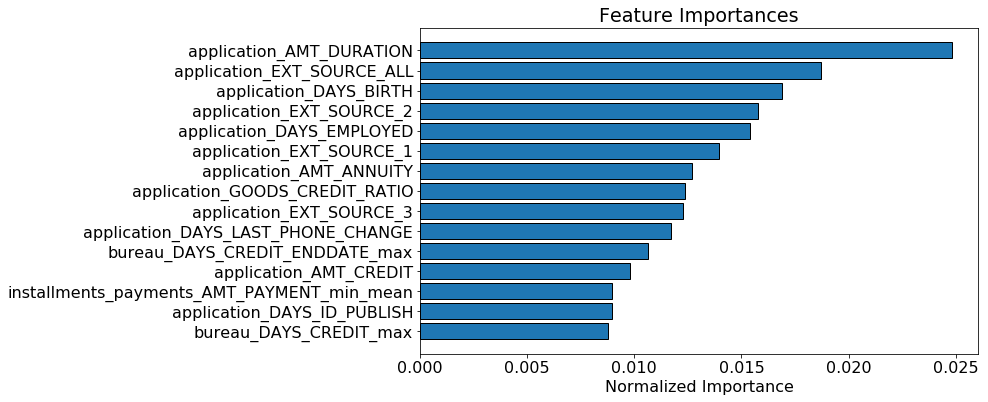

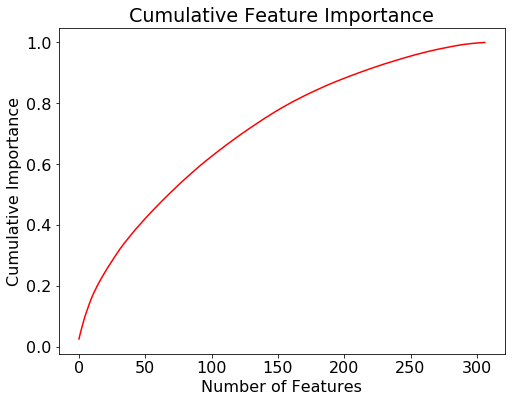

246 features required for 0.95 of cumulative importance


In [14]:
# Importance des variables du modele LGBM
norm_feature_importances = f.plot_feature_importances(feature_importance_df,
                                                      threshold = 0.95)


# 5. Interpretabilité du modèle
Pour interpréter les sorties du modèles, on va utiliser les valeurs de Shapley.<br>
Elles correspondent à la contribution de chaque variable pour une prédiction donnée. Il s'agit de la valeur marginale moyenne, apportée par la variable, dans toutes les combinaisons possibles de variables dont elle fait partie.<br>
Pour les calculer, on initialise un modèle standard de ``lightgbm`` (compatible avec la librairie ``shap``) avec les paramètres du modèle sélectionné. 

In [15]:
# Parametres du modele selectionné
params = model.get_params()
params['metric'] = 'binary_logloss'
num_boost = params['n_estimators']

train_set = lgb.Dataset(data=X_train_balanced, label=y_train_balanced)

# Entrainenemnt modele lgb pour calcul des valeurs SHAP
mod = lgb.train(params,
                train_set,
                num_boost,
                valid_sets=train_set,
                early_stopping_rounds= 100,
                verbose_eval= 10)

c:\users\prime\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\users\prime\appdata\local\programs\python\python37\lib\site-packages\lightgbm\basic.py:794: UserWarning:

silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.



Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.636565
[20]	training's binary_logloss: 0.602517
[30]	training's binary_logloss: 0.578503
[40]	training's binary_logloss: 0.560475
[50]	training's binary_logloss: 0.545836
[60]	training's binary_logloss: 0.533048
[70]	training's binary_logloss: 0.521783
[80]	training's binary_logloss: 0.511422
[90]	training's binary_logloss: 0.502154
[100]	training's binary_logloss: 0.493536
[110]	training's binary_logloss: 0.485111
[120]	training's binary_logloss: 0.477257
[130]	training's binary_logloss: 0.469749
[140]	training's binary_logloss: 0.462714
[150]	training's binary_logloss: 0.456217
[160]	training's binary_logloss: 0.44974
[170]	training's binary_logloss: 0.44379
[180]	training's binary_logloss: 0.437862
[190]	training's binary_logloss: 0.432654
[200]	training's binary_logloss: 0.427251
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.427251


On créé un sous-échantillon des données test avec les classes équilibrées.

In [16]:
# Echantillon de données test avec classes équilibrées
target_0 = y_test[y_test['TARGET'] == 0]
target_1 = y_test[y_test['TARGET'] == 1]

# Sous-échantillon de la classe 0,
# de même longueur que l'échantillon de la classe 1
target_0_sample = target_0.sample(len(target_1), random_state=RANDOM_STATE)

# Sous-echantillons des données de test 
# avec classes équilibrées
y_test_balanced = pd.concat([target_0_sample, target_1], axis=0)
X_test_balanced = X_test.loc[y_test_balanced.index, :]

# Dimensions des sous échantillons avec classes équilibrées
print(X_test_balanced.shape)
print(y_test_balanced.shape)

(14896, 307)
(14896, 1)


On  peut alors calculer les valeurs de Shapley sur un échantillon des données test avec classes équilibrées.<br>
On prend un échantillon de taille moyenne, car le temps de calcul des valeurs est relativement long.

In [17]:
# Calcul des valeurs SHAP sur échantillon des données test
shap_sample = X_test_balanced.sample(1000, random_state=RANDOM_STATE)
shap_values = shap.TreeExplainer(mod).shap_values(shap_sample.values)[1]

c:\users\prime\appdata\local\programs\python\python37\lib\site-packages\shap\explainers\tree.py:104: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.

c:\users\prime\appdata\local\programs\python\python37\lib\site-packages\shap\explainers\tree.py:232: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



On créé ensuite un tableau des valeurs Shapley par client.

In [18]:
# Dataframe des valeurs SHAP
shap_df = pd.DataFrame(data=shap_values,
                       index=shap_sample.index,
                       columns=shap_sample.columns)
shap_df.head()

,application_EXT_SOURCE_ALL,application_AMT_DURATION,application_DAYS_EMPLOYED,application_GOODS_CREDIT_RATIO,application_EXT_SOURCE_1,application_DAYS_BIRTH,application_EXT_SOURCE_2,application_EXT_SOURCE_3,application_AMT_ANNUITY,installments_payments_AMT_PAYMENT_min_mean,...,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,card_balance_AMT_INST_MIN_REGULARITY_sum_min,installments_payments_NUM_INSTALMENT_NUMBER_max_min,installments_payments_DIFF_max_mean,card_balance_AMT_DRAWINGS_ATM_CURRENT_sum_sum,bureau_balance_STATUS_max_min,cash_balance_CNT_INSTALMENT_count_min,cash_balance_CNT_INSTALMENT_min_min,application_NONLIVINGAPARTMENTS_AVG,previous_PRODUCT_COMBINATION_Cash Street: high_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
214748,-0.014057,0.048282,-0.102412,-0.215193,0.025074,0.004813,-0.074052,-0.035700,0.052067,-0.118303,...,0.019404,0.002790,0.005530,0.006946,0.004049,-0.000069,0.000580,0.005255,-0.000508,-0.000887
412443,-0.168494,0.059459,-0.095932,0.329413,-0.137648,0.008356,-0.031056,-0.064149,0.137752,-0.023277,...,0.000694,-0.000146,-0.000803,-0.000973,0.001936,0.000192,0.000556,-0.001900,-0.000393,-0.000839
315795,0.443357,0.073672,0.067006,-0.004878,0.118645,0.052693,-0.051335,0.034522,0.093559,-0.049620,...,-0.000287,0.000133,-0.000472,-0.002219,0.001168,-0.000064,0.000762,0.002494,0.001281,-0.002266
107328,0.147083,0.056245,0.088097,0.222814,-0.023692,-0.012379,-0.190725,0.105222,0.102450,-0.031342,...,-0.000971,0.002727,0.001049,-0.002106,-0.036801,0.004462,0.002988,-0.000250,0.001844,-0.001025
195002,-0.436999,0.085294,-0.061249,-0.169957,0.061936,0.048753,-0.038810,-0.029230,0.086923,-0.016137,...,0.021405,-0.000157,0.002832,-0.004098,-0.000916,-0.000004,0.000478,0.003329,-0.000417,-0.000850


Pour évaluer l'impact des variable sur le modèle, on visualise la distribution des valeurs par variable pour tous les individus de l'échantillon.  

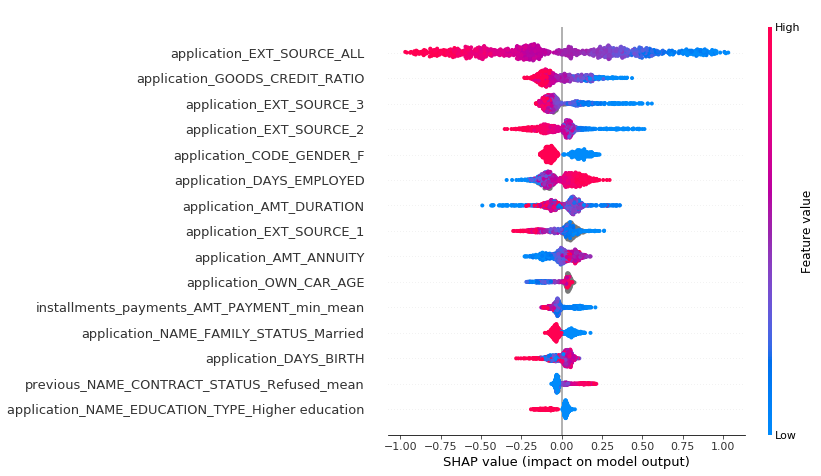

In [19]:
# Impact des variables sur étiquettes à prédire
plt.figure(figsize=(7,6))
shap.summary_plot(shap_df.values, shap_sample,
                  max_display=15)
plt.show()

# 6. Sauvegarde des données pour le dashboard et l'API
#### Echantillon clients avec valeurs Shapley pour dashboard

In [20]:
# Sauvegarde échantillon clients avec SHAP values pour dashboard
#shap_sample.sort_index().to_csv('data/dashboard/dash_shap_sample.csv')
shap_df.sort_index().to_csv('data/dashboard/dash_shap_values.csv')

#### Importance des variables avec LightGBM pour dashboard

In [21]:
# Données dashboard pour interprétabilité du modele
feature_importance_df['group_feature'] = \
    feature_importance_df['feature'].apply(lambda x: x.split('_')[0])

# Calcul importance normalisée des variables
feature_importance_df['importance_normalized'] = \
    feature_importance_df.importance / feature_importance_df.importance.sum()

# Sauvegarde pour dashboard de l'importance des variables pour le modèle
feature_importance_df.to_csv('data/dashboard/dash_feature_importances.csv')

#### Calcul des probabilités de défaut de tous les clients pour dashboard

In [22]:
# Données pour dashboard, features de tous les clients
X_dash = pd.concat([X_train, X_test])

# Prédictions de tous les clients
y_dash = model.predict(X_dash)

# Probabilités de defaut pour dashboard
dash_proba = pd.DataFrame(index=X_dash.index)
dash_proba.index.name = 'client'
dash_proba['default_proba'] = np.round(y_dash * 100, 2)
dash_proba.head()

#Sauvegarde pour dashboard des prédictions de défaut par client
dash_proba.to_csv('data/dashboard/dash_proba.csv')

In [23]:
# Clients de l'échantillon du dashboard qui dépasse le seuil de risque de 91.7936%
sample_proba = shap_sample.merge(dash_proba,
                                 how='inner',
                                 left_index=True,
                                 right_index=True)

display(sample_proba[sample_proba.default_proba > 91.7936]\
        .loc[:, ['default_proba']]\
        .sort_index())

,default_proba
111548,91.90
129061,92.89
177300,94.21
200682,93.10
220996,95.00
267160,92.29
285223,92.29
305482,93.19
336299,92.98
429894,93.68


#### Modèle et échantillon de clients pour API

In [24]:
# Données pour API
# Sauvegarde du modèle
obj_to_save = model
file_save = 'data/API/model.sav'
pickle.dump(obj_to_save, open(file_save, 'wb'))

# Sauvegarde d'un échantillon des données pour API
X_test_balanced\
    .sample(n=1000, random_state=RANDOM_STATE)\
    .sort_index()\
    .to_csv("data/API/sample_input.csv")

In [25]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 223.249765 sec
computing time : 00:03:43
